## Risk Plots

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import sys
import qinfer as qi
import models as m_
import time 
from adaptive import *
from nvdata import *
import time
import resource
import seaborn as sns

### Parallelization Setup

The following sets up the `dview` object used for parallelizing models across CPU cores. Go to the Jupyter "IPython Clusters" tab to start up the default cluster.

In [2]:
from ipyparallel import Client
rc = Client(profile='default')
dview = rc[:]
dview.use_dill()

with dview.sync_imports():
    import os

# Change directory on engines so that we can import models.
if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
    print "Changed engine directories to notebook directory."

# To ensure that we don't enter into a Matplotlib event loop
# on our engines, we set the MPLBACKEND to the non-interactive
# Agg backend first. This is especially useful if the engines
# are connected via SSH.
if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
    print "Changed MPL backend."

# Force each engine to import QInfer before proceeding.
if dview.execute('import qinfer as qi').get():
    print "Successfully imported QInfer on engines."

if dview.execute('import models').get():
    print "Successfully imported models."

print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 8


### Models

In [3]:
ham_model = m.RabiRamseyModel()
ex_model = m.RabiRamseyExtendedModel(10, 3)
par_ham_model = qi.DirectViewParallelizedModel(ham_model, dview)
par_ex_model = qi.DirectViewParallelizedModel(ex_model, dview)
no_parallel_ref_model = m.ReferencedPoissonModel(ham_model)
par_ref_model =  m.ReferencedPoissonModel(par_ham_model,dview=dview)

### Convenient Prior for testing risk

`custom_prior(1)` is roughly the posterior after one experimental trial, `custom_prior(200)` is a very wide prior with the same mean.

In [4]:
true_value = np.array([11.6,1.79,1.74778949,2.22,0.61])
target_stds = np.array([0.01,0.01,0.15,0.02,0.05])
def custom_prior(multiplier):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(multiplier * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(multiplier * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(multiplier * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(multiplier * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(multiplier * target_stds[4])**2),
    )

def extended_prior(multiplier):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(multiplier * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(multiplier * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(multiplier * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(multiplier * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(multiplier * target_stds[4])**2),
        *([qi.GammaDistribution(mean=1, var=(0.01)**2)] * 6)
    )

ref_prior = qi.UniformDistribution(
    [[0.019,0.021],[0.014,0.016]]
)

def drift_prior(multiplier):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(multiplier * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(multiplier * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(multiplier * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(multiplier * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(multiplier * target_stds[4])**2),
        qi.UniformDistribution([[0.017,0.021],[0.014,0.017]])
    )


### Comparison of Full risk with Bernoulli

In [5]:
subsample_particles = 512
outcome_samples = 512
n_eps = 200
N = 100
n_particles = 10000

<IPython.core.display.Javascript object>


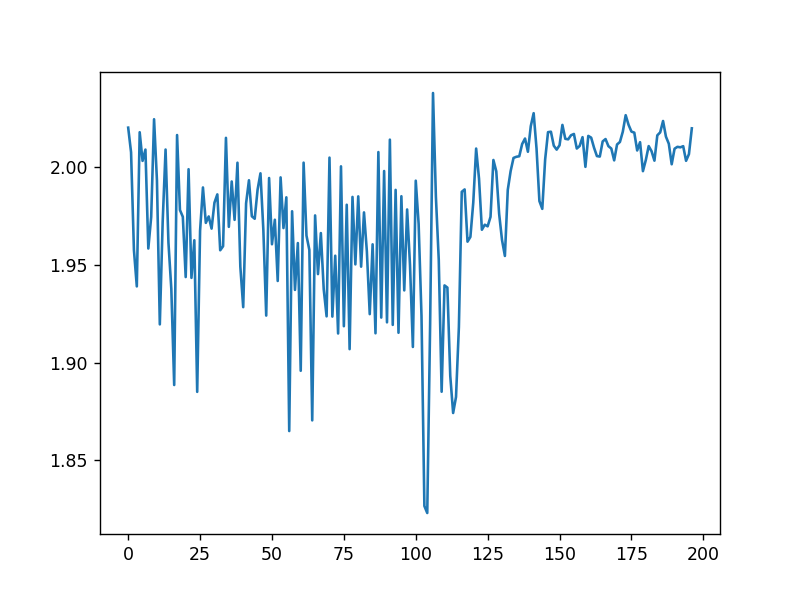

In [6]:
string = """
[2.01613312 2.02041251 2.00781008 1.95764765 1.93905175 2.0180611
 2.00337649 2.009171   1.95847035 1.97466507 2.02471754 1.99344706
 1.9195884  1.97243006 2.00918968 1.96151882 1.93777227 1.88851722
 2.01662389 1.97820817 1.97470981 1.94384224 1.99911109 1.94341893
 1.96271303 1.88500992 1.96755664 1.98976028 1.9716098  1.97491767
 1.96866812 1.9819549  1.98620578 1.95756509 1.95964597 2.0151809
 1.9695668  1.99282936 1.97314757 2.00243994 1.94917749 1.92841958
 1.98159896 1.99345002 1.9749905  1.9737205  1.98863638 1.99700763
 1.96813726 1.92409697 1.99460004 1.96065324 1.97321677 1.94183708
 1.99492423 1.96894592 1.98470297 1.86492582 1.9775563  1.93725366
 1.96127124 1.8958124  2.00247264 1.96509291 1.95771847 1.87039879
 1.97543079 1.94535346 1.966385   1.93756489 1.92370579 2.00505205
 1.92357519 1.9547819  1.91492424 2.00058044 1.91864823 1.98089801
 1.90689603 1.98491008 1.95033278 1.9851889  1.94916292 1.97697683
 1.95699911 1.92483784 1.96062216 1.91502322 2.00789492 1.92307241
 1.99819086 1.92063367 2.01425928 1.91932994 1.98851998 1.91529221
 1.98526538 1.93700157 1.97847693 1.95000971 1.9080181  1.99323077
 1.9710776  1.92391014 1.82652699 1.82293471 1.9197237  2.03816291
 1.98512397 1.95265633 1.88507002 1.93956355 1.93843997 1.89320512
 1.87417722 1.88239991 1.91823277 1.98752237 1.98875355 1.96198755
 1.96440673 1.9820536  2.0096907  1.99426553 1.96809294 1.97066241
 1.96984256 1.97469191 2.00383526 1.99805299 1.97618298 1.96280759
 1.95465216 1.98852918 1.99817971 2.00489252 2.00547939 2.00575254
 2.01202007 2.01483411 2.00805021 2.02117864 2.02782292 2.00968839
 1.98278562 1.97878893 2.00417359 2.01809904 2.01832919 2.01116854
 2.00914599 2.01137393 2.0218101  2.01469042 2.0144144  2.01651449
 2.01716613 2.00971324 2.01102397 2.0155252  2.00031685 2.01617557
 2.0152849  2.0101094  2.0058331  2.00558481 2.01335237 2.01455963
 2.01091385 2.00970348 2.00363964 2.01178411 2.01306465 2.01833161
 2.02678724 2.02186138 2.0183877  2.01784708 2.00871564 2.01294704
 1.99810881 2.00379549 2.01096013 2.00832091 2.00348663 2.0164585
 2.01799122 2.02381825 2.01579236 2.01215629 2.00164536 2.0096215
 2.01058171 2.01032127 2.01090434 2.00342427 2.0068344  2.02006283
 2.01014606 1.99711532]
"""
plt.figure()
plt.plot(np.array(
    map(float, string.replace('\n','').replace('[','').replace(']','').replace('  ',' ').replace('  ',' ').split(' ')[1:-2])
    ))

In [8]:
n_particle_subset = [250,500,1000,2000,3000]
n_outcome_samples = [10,100,250,500,1000,2000,3000]
#n_particle_subset = [50,100]
#n_outcome_samples = [10,100]
l_n_p = len(n_particle_subset)
l_n_o = len(n_outcome_samples)
times = np.zeros((l_n_p,l_n_o))
memory = np.zeros((l_n_p,l_n_o))
mean_msd = np.zeros((l_n_p,l_n_o))
n_eps = 200
Q = np.ones(7)
Q[5:7] = 0.
par_ref_model._underlying_model._Q = Q 
par_ref_model.Q
updater_2E5 = qi.SMCUpdater(par_ref_model,n_particles, drift_prior(5),dview=dview)
rabi_eps_2E5 = rabi_sweep(max_t=1, n=200, wo=0,n_meas=200000,mode=0)
all_eps = np.concatenate([rabi_sweep(max_t=1, n=int(n_eps/2), n_meas=200000), 
ramsey_sweep(max_tau=2, n=int(n_eps/2), n_meas=200000)])

ris = {}
for i,n_p in enumerate(n_particle_subset):
    ris[n_p] = {}
    for j,n_o in enumerate(n_outcome_samples):
        start = time.time()
        par_ref_model._n_outcomes = n_o
        ri = updater_2E5.risk_improvement(all_eps,n_particle_subset=n_p,var_fun='simplified',batch=None)
        ris[n_p][n_o] = ri
        stop = time.time()
        total_time = stop-start
        times[i,j] = total_time
        memory[i,j] = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
        print 'n_o={0},n_p={1} time={2}s'.format(n_o,n_p,total_time)
        
best_ri = ris[n_particle_subset[-1]][n_outcome_samples[-1]]
for i,n_p in enumerate(n_particle_subset):
    for j,n_o in enumerate(n_outcome_samples):
        mean_msd[i,j] = np.mean((best_ri-ris[n_p][n_o])**2)


n_o=10,n_p=250 time=1.44814109802s
n_o=100,n_p=250 time=1.36263418198s
n_o=250,n_p=250 time=2.07660698891s
n_o=500,n_p=250 time=31.0324909687s


KeyboardInterrupt: 

In [9]:
updater_2E5.model

In [7]:
from matplotlib.colors import LogNorm

In [10]:
mean_msd

array([[0.00404029, 0.00149295],
       [0.0031102 , 0.        ]])

<IPython.core.display.Javascript object>


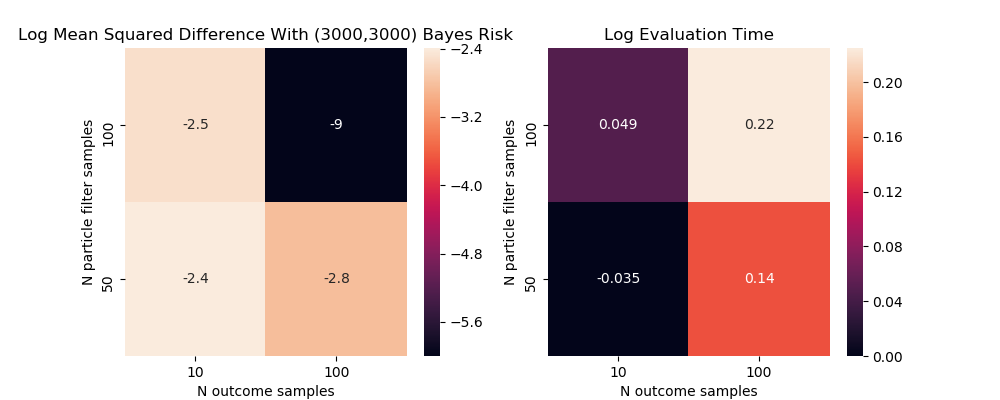

Text(0.5,1,u'Log Evaluation Time')

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
log_msd = np.log10(mean_msd+1E-9)
sns.heatmap(np.flip(log_msd,axis=0), vmin=-6,vmax=np.amax(log_msd),yticklabels=np.flip(n_particle_subset,axis=0),xticklabels=n_outcome_samples,ax=ax[0],
           annot=True)
ax[0].set_xlabel('N outcome samples')
ax[0].set_ylabel('N particle filter samples')
ax[0].set_title('Log Mean Squared Difference With (3000,3000) Bayes Risk')

log_time= np.log10(times)
sns.heatmap(np.flip(log_time,axis=0), vmin=0,yticklabels=np.flip(n_particle_subset,axis=0),xticklabels=n_outcome_samples,ax=ax[1],annot=True)
ax[1].set_xlabel('N outcome samples')
ax[1].set_ylabel('N particle filter samples')
ax[1].set_title('Log Evaluation Time')

In [24]:
subsample_particles = 1024
outcome_samples = 512*2

In [13]:
drift_prior = qi.UniformDistribution(
    [[0.017,0.021],[0.014,0.017]]
)
adaptive_prior = qi.ProductDistribution(custom_prior(2), drift_prior)


### Risk Heuristic

In [14]:
adaptive_updater = m.BridgedRPMUpdater(par_ref_model, n_particles, adaptive_prior)

bin_heuristic = RiskHeuristic(
    adaptive_updater, 
    [1.,1.,1.,1.,1.], 
    rabi_sweep(max_t=1, n=int(n_eps/2), n_meas=200000), 
    ramsey_sweep(max_tau=2, n=int(n_eps/2), n_meas=200000),
    dview=dview,subsample_particles=subsample_particles
)

%timeit -n 1 -r 1 bin_min_risk = bin_heuristic(0.022)
bin_min_risk = bin_heuristic(0.022)

1 loop, best of 1: 6.45 s per loop


In [15]:
print bin_min_risk

[(0.76, 0., 0., 0., 0, 0, 200000)]


In [16]:
#%lprun -f bin_heuristic._risk_taker.model.underlying_model.likelihood bin_heuristic(0.022)

### Full Risk Heuristic

In [17]:
n_eps

200

In [25]:
ham_model = m.RabiRamseyModel()
ex_model = m.RabiRamseyExtendedModel(10, 3)
par_ham_model = qi.DirectViewParallelizedModel(ham_model, dview)
par_ex_model = qi.DirectViewParallelizedModel(ex_model, dview)
no_parallel_ref_model = m.ReferencedPoissonModel(ham_model)
par_ref_model =  m.ReferencedPoissonModel(par_ham_model,dview=dview)
#par_ref_model._n_outcomes = outcome_samples
adaptive_updater =  qi.SMCUpdater(par_ref_model, n_particles, adaptive_prior,dview=dview)
full_heuristic = FullRiskHeuristic(
    adaptive_updater, 
    np.array([1.,1.,1.,1.,1.,0.,0.]), 
    rabi_sweep(max_t=1, n=int(n_eps/2), n_meas=200000), 
    ramsey_sweep(max_tau=2, n=int(n_eps/2), n_meas=200000),
    dview=dview,subsample_particles=subsample_particles,n_outcome_samples=outcome_samples,
    var_fun='simplified',batch=None)

%timeit -n 1 -r 1 full_heuristic(0.022)
#full_min_risk = full_heuristic(0.022)

1 loop, best of 1: 17.1 s per loop


In [19]:
#%lprun -f adaptive_updater.model.likelihood full_heuristic(0.022)

In [20]:
print full_min_risk

[(0.76, 0., 0., 0., 0, 0, 200000)]
